# ***NOTEBOOK FOR `ANALYSING` THE `OLIST` DATA***
***

- **GOAL IS TO FIND STRONG REASONS BEHIND LOW REVIEW SCORE**

## ***Starting of Analysis***

### ***Data Import, Creating Connection and Checking the data***

In [1]:
import os
from pathlib import Path

def get_project_root(project_name="portfolio_projects"):
    """
    Universally finds the project root.
    1. Checks if we are inside the project (standard usage).
    2. Checks if we are above the project (your specific usage).
    """
    current_path = Path.cwd()

    # CASE 1: Standard Usage (Running from inside the repo)
    if project_name in str(current_path):
        while current_path.name != project_name:
            current_path = current_path.parent
        return current_path

    # CASE 2: Your Setup (Running from 'Machine' or a parent folder)
    # We search specifically for the project folder inside the current directory
    # limiting depth to 4 levels to keep it fast.
    else:
        # rglob searches recursively for the folder name
        for path in current_path.rglob(project_name):
            if path.is_dir():
                return path
        
        raise FileNotFoundError(f"Could not find project: {project_name}")

# --- USAGE ---
repo_root = get_project_root()

data_path = repo_root / "inside_olist_review_analysis"
print(data_path)

C:\Users\Rano's PC\Machine\PORTFOLIO_PROJECTS\inside_olist_review_analysis


In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath(f"{data_path}"))

import src.plots as P
import src.stat_tests as S

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
file_path = data_path / "dataset" / "processed_data" / "processed_olist_data.csv"

data = pd.read_csv(file_path)

In [5]:
pd.set_option('display.max_columns',None)

In [6]:
data.head()

,review_score,review_creation_date,total_unique_products,total_items,total_order_value,total_freight,avg_price,avg_freight,is_multiple_seller,primary_payment_type,max_attempt,installment_duration,total_paid_value,order_status,approval_time_days,delivery_time_days,seller_processing_days,transit_days,delivery_diff_days,is_late,category_name,dimensional_weight,product_photos_qty,paid_extra,extra_cost,reviewed_before_delivery,days_to_review,review_month,review_year,is_weekend_review,day_of_review
0,high,2018-01-18,1,2,370.00,27.26,185.00,13.63,NO,credit_card,1,8,397.26,delivered,0.0,6.0,1.0,5.0,-16.0,NO,1,10.50,1,NO,0.0,NO,1,1,2018,NO,Thursday
1,high,2018-03-10,1,1,79.79,8.30,79.79,8.30,NO,credit_card,1,1,88.09,delivered,0.0,9.0,2.0,7.0,-5.0,NO,1,0.62,1,NO,0.0,NO,1,3,2018,YES,Saturday
2,high,2018-02-17,1,1,149.00,45.12,149.00,45.12,NO,credit_card,1,1,194.12,delivered,0.0,13.0,3.0,10.0,-21.0,NO,1,1.33,1,NO,0.0,NO,1,2,2018,YES,Saturday
3,high,2017-04-21,1,1,179.99,42.85,179.99,42.85,NO,credit_card,1,1,222.84,delivered,0.0,11.0,1.0,10.0,-20.0,NO,1,1.33,2,NO,0.0,NO,1,4,2017,NO,Friday
4,high,2018-03-01,1,1,1199.00,134.25,1199.00,134.25,NO,credit_card,1,10,1333.25,delivered,0.0,18.0,5.0,13.0,-9.0,NO,1,30.62,5,NO,0.0,NO,1,3,2018,NO,Thursday


### ***Initial Health Check***

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   review_score              99224 non-null  object 
 1   review_creation_date      99224 non-null  object 
 2   total_unique_products     99224 non-null  int64  
 3   total_items               99224 non-null  int64  
 4   total_order_value         99224 non-null  float64
 5   total_freight             99224 non-null  float64
 6   avg_price                 99224 non-null  float64
 7   avg_freight               99224 non-null  float64
 8   is_multiple_seller        99224 non-null  object 
 9   primary_payment_type      99224 non-null  object 
 10  max_attempt               99224 non-null  int64  
 11  installment_duration      99224 non-null  int64  
 12  total_paid_value          99224 non-null  float64
 13  order_status              99224 non-null  object 
 14  approv

In [8]:
rows,columns = data.shape
print(f"Rows -> {rows}")
print(f"Columns -> {columns}")

Rows -> 99224
Columns -> 31


In [9]:
data.isnull().sum()[data.isnull().sum()>0].reset_index(name = 'null_counts')

,index,null_counts
0,approval_time_days,156
1,delivery_time_days,2865
2,seller_processing_days,1770
3,transit_days,2866
4,delivery_diff_days,2865


In [10]:
data.duplicated().sum()

np.int64(279)

- ***There are duplicate values***

In [11]:
data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
total_unique_products,99224.0,1.03,0.24,0.00,1.00,1.00,1.00,8.00
total_items,99224.0,1.13,0.54,0.00,1.00,1.00,1.00,21.00
total_order_value,99224.0,136.33,208.67,0.00,45.00,85.00,149.90,13440.00
total_freight,99224.0,22.62,21.60,0.00,13.71,17.09,23.91,1794.96
avg_price,99224.0,124.60,188.92,0.00,40.00,78.90,139.00,6735.00
avg_freight,99224.0,20.02,15.81,0.00,13.18,16.32,21.15,409.68
max_attempt,99224.0,1.05,0.38,0.00,1.00,1.00,1.00,29.00
installment_duration,99224.0,2.93,2.72,0.00,1.00,2.00,4.00,24.00
total_paid_value,99224.0,160.56,220.32,0.00,61.88,105.28,176.71,13664.08
approval_time_days,99068.0,0.52,1.17,0.00,0.00,0.00,1.00,188.00


### ***Knowledge from initial health check***

- **negative values in `seller_processing_days`**

- **negative values in `transit_days`**

In [12]:
data[data['seller_processing_days']<0]

,review_score,review_creation_date,total_unique_products,total_items,total_order_value,total_freight,avg_price,avg_freight,is_multiple_seller,primary_payment_type,max_attempt,installment_duration,total_paid_value,order_status,approval_time_days,delivery_time_days,seller_processing_days,transit_days,delivery_diff_days,is_late,category_name,dimensional_weight,product_photos_qty,paid_extra,extra_cost,reviewed_before_delivery,days_to_review,review_month,review_year,is_weekend_review,day_of_review
165,high,2018-08-21,1,1,199.99,9.31,199.99,9.31,NO,credit_card,1,1,209.30,delivered,6.0,6.0,-3.0,3.0,-3.0,NO,1,0.29,1,NO,0.0,NO,1,8,2018,NO,Tuesday
201,low,2018-05-08,1,1,64.99,27.51,64.99,27.51,NO,credit_card,1,3,92.50,delivered,3.0,16.0,-1.0,14.0,-25.0,NO,1,0.49,1,NO,0.0,NO,1,5,2018,NO,Tuesday
219,high,2018-07-11,1,1,210.00,23.29,210.00,23.29,NO,credit_card,1,4,233.29,delivered,2.0,7.0,-2.0,7.0,-13.0,NO,1,7.00,1,NO,0.0,NO,1,7,2018,NO,Wednesday
341,low,2018-07-06,1,1,32.00,7.48,32.00,7.48,NO,credit_card,1,1,39.48,delivered,2.0,2.0,-2.0,2.0,-11.0,NO,1,2.64,6,NO,-0.0,NO,1,7,2018,NO,Friday
419,low,2017-12-15,1,1,139.90,14.00,139.90,14.00,NO,debit_card,1,1,153.90,delivered,2.0,7.0,-1.0,6.0,-17.0,NO,1,0.38,3,NO,0.0,NO,5,12,2017,NO,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97569,high,2018-04-28,1,1,195.00,25.02,195.00,25.02,NO,credit_card,1,4,220.02,delivered,3.0,6.0,-1.0,4.0,-18.0,NO,1,6.87,2,NO,0.0,NO,1,4,2018,YES,Saturday
98183,high,2018-08-18,1,1,77.90,14.86,77.90,14.86,NO,credit_card,1,9,92.76,delivered,5.0,10.0,-3.0,8.0,-2.0,NO,1,3.53,1,NO,0.0,NO,4,8,2018,YES,Saturday
98288,high,2018-06-05,1,2,35.80,30.46,17.90,15.23,NO,credit_card,1,3,66.26,delivered,3.0,14.0,-3.0,14.0,-2.0,NO,1,4.50,1,NO,0.0,NO,1,6,2018,NO,Tuesday
98723,high,2018-07-10,1,1,109.90,15.87,109.90,15.87,NO,boleto,1,1,125.77,delivered,2.0,6.0,-1.0,5.0,-15.0,NO,1,0.32,2,NO,-0.0,NO,1,7,2018,NO,Tuesday


In [13]:
data = data[~(data['seller_processing_days']<0)]

In [14]:
data[data['transit_days']<0]

,review_score,review_creation_date,total_unique_products,total_items,total_order_value,total_freight,avg_price,avg_freight,is_multiple_seller,primary_payment_type,max_attempt,installment_duration,total_paid_value,order_status,approval_time_days,delivery_time_days,seller_processing_days,transit_days,delivery_diff_days,is_late,category_name,dimensional_weight,product_photos_qty,paid_extra,extra_cost,reviewed_before_delivery,days_to_review,review_month,review_year,is_weekend_review,day_of_review
11279,high,2017-02-15,2,2,281.99,44.79,141.00,22.40,YES,credit_card,1,2,326.78,delivered,0.0,4.0,20.0,-16.0,-29.0,NO,1,8.96,2,NO,-0.00,NO,1,2,2017,NO,Wednesday
20631,high,2017-08-01,2,7,106.60,114.25,15.23,16.32,YES,boleto,1,1,220.86,delivered,1.0,5.0,5.0,-1.0,-24.0,NO,1,9.70,1,YES,0.01,NO,1,8,2017,NO,Tuesday
28539,low,2017-07-07,2,2,83.80,27.44,41.90,13.72,YES,credit_card,1,7,111.24,delivered,0.0,4.0,5.0,-1.0,-15.0,NO,1,1.79,4,NO,0.00,NO,1,7,2017,NO,Friday
33723,low,2017-03-29,2,2,89.00,25.07,44.50,12.54,YES,credit_card,1,2,114.07,delivered,0.0,6.0,8.0,-2.0,-15.0,NO,1,3.62,6,NO,0.00,NO,1,3,2017,NO,Wednesday
37963,low,2016-10-22,1,1,99.99,11.23,99.99,11.23,NO,boleto,1,1,111.22,delivered,4.0,13.0,10.0,-1.0,-40.0,NO,1,5.87,1,NO,0.00,NO,2,10,2016,YES,Saturday
43720,low,2017-07-26,2,2,157.00,30.59,78.50,15.29,YES,credit_card,1,9,187.59,delivered,0.0,7.0,9.0,-2.0,-21.0,NO,2,0.91,1,NO,0.00,NO,1,7,2017,NO,Wednesday
57125,low,2017-07-20,2,2,124.80,15.26,62.40,7.63,YES,boleto,1,1,140.06,delivered,2.0,3.0,2.0,-1.0,-20.0,NO,2,1.14,3,NO,0.00,NO,1,7,2017,NO,Thursday
59948,low,2017-02-11,2,2,108.60,20.51,54.30,10.26,YES,credit_card,1,3,129.11,delivered,0.0,6.0,11.0,-5.0,-19.0,NO,2,3.50,1,NO,0.00,NO,1,2,2017,YES,Saturday
60469,high,2017-06-03,2,2,289.98,30.81,144.99,15.40,YES,credit_card,1,4,320.79,delivered,0.0,4.0,11.0,-7.0,-21.0,NO,2,2.68,3,NO,0.00,NO,1,6,2017,YES,Saturday
61050,high,2017-08-04,2,2,104.90,24.78,52.45,12.39,YES,credit_card,1,4,129.68,delivered,1.0,4.0,4.0,-1.0,-15.0,NO,1,0.95,4,NO,0.00,NO,1,8,2017,NO,Friday


In [15]:
data = data[~(data['transit_days']<0)]

In [16]:
data.drop_duplicates(inplace=True)

In [17]:
rows,columns = data.shape
print(f"Rows -> {rows}")
print(f"Columns -> {columns}")

Rows -> 98249
Columns -> 31


In [18]:
data.select_dtypes(include='object').describe().T

,count,unique,top,freq
review_score,98249,2,high,75661
review_creation_date,98249,636,2017-12-19,460
is_multiple_seller,98249,3,NO,96262
primary_payment_type,98249,6,credit_card,74134
order_status,98249,8,delivered,95411
is_late,98249,2,NO,91857
paid_extra,98249,2,NO,97146
reviewed_before_delivery,98249,2,NO,92810
is_weekend_review,98249,2,NO,74233
day_of_review,98249,7,Wednesday,18927


In [19]:
data['review_creation_date']=pd.to_datetime(data['review_creation_date'])

### ***Univariate Analysis***

**review_score**

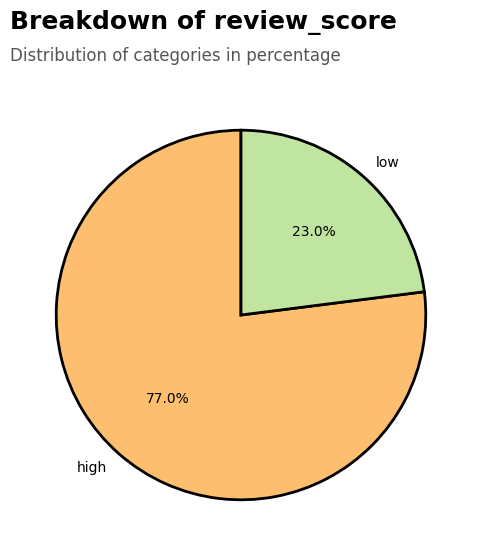

In [20]:
plt.figure(figsize=(6,6))
P.plot_pie('review_score',data)

- Approx 20% of reviews are low reviews in this dataset

**total_unique_products**

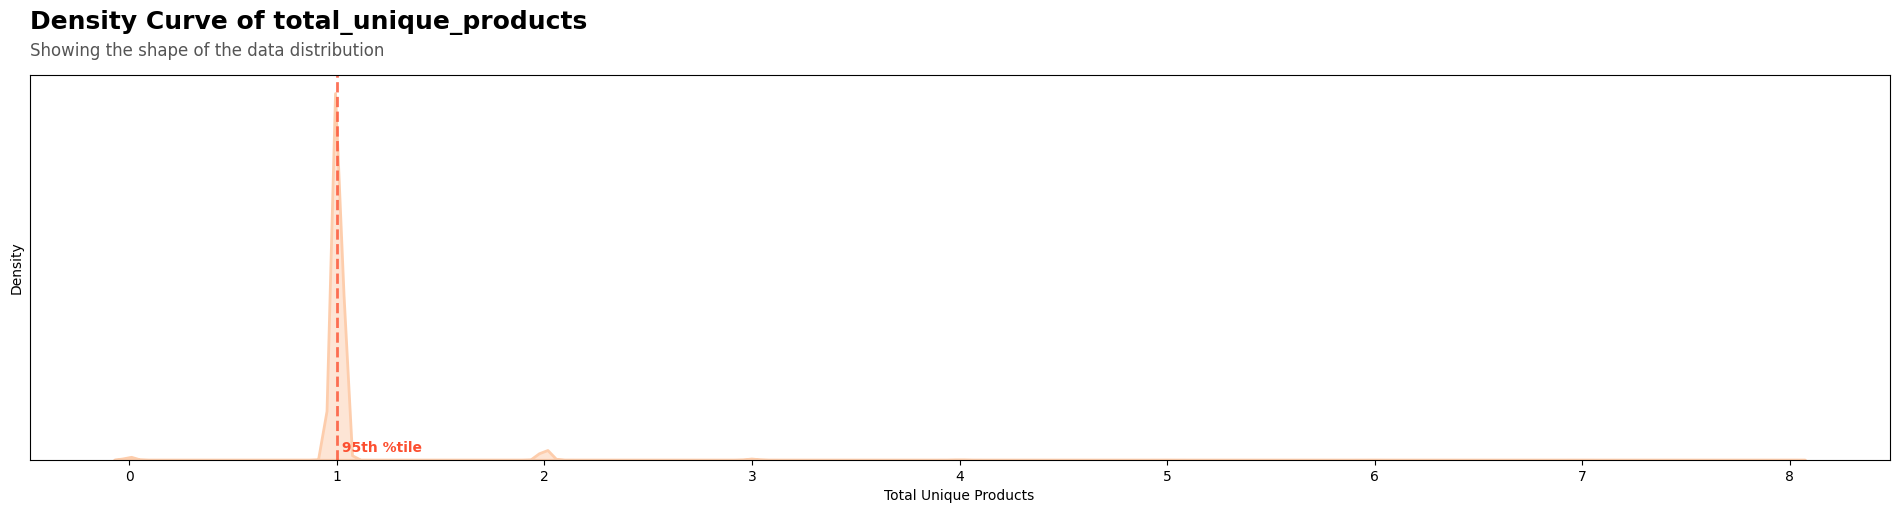

In [21]:
plt.figure(figsize=(24,5))
P.plot_kde('total_unique_products',data)

In [22]:
data['total_unique_products'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

,total_unique_products,percentage
0,1,96.01
1,2,2.84
2,0,0.76
3,3,0.30
4,4,0.07
5,6,0.01
6,5,0.01
7,7,0.00
8,8,0.00


In [23]:
bins = [-1, 0, 1, 100]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['total_unique_products'] = pd.cut(data['total_unique_products'], bins=bins, labels=labels)

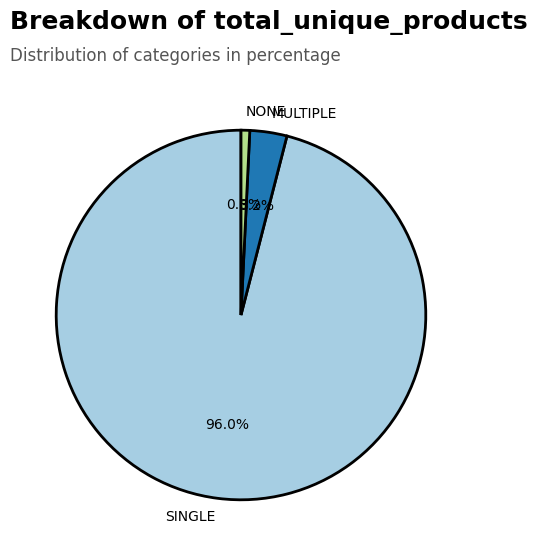

In [24]:
plt.figure(figsize=(6,6))
P.plot_pie('total_unique_products',data)

- 96% of the observation have single unique products

**total_items**

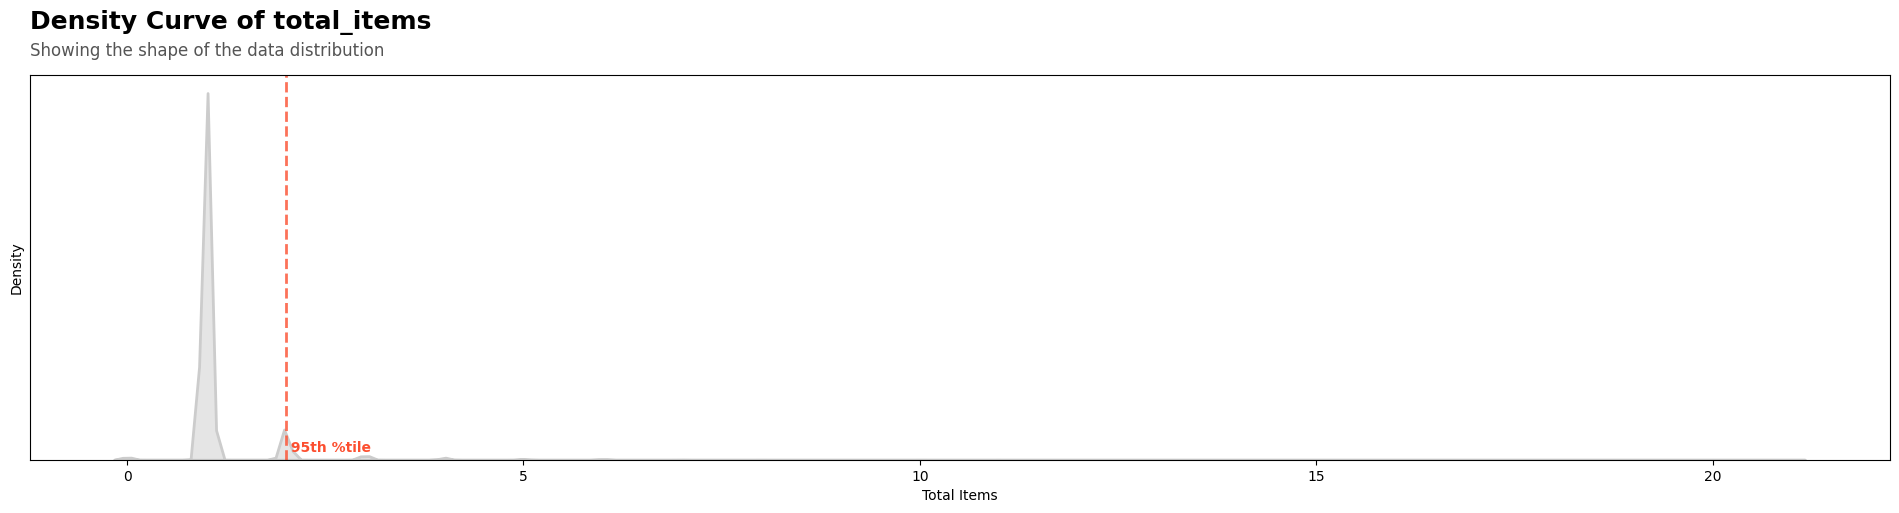

In [25]:
plt.figure(figsize=(24,5))
P.plot_kde('total_items',data)

In [26]:
data['total_items'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

,total_items,percentage
0,1,89.41
1,2,7.54
2,3,1.33
3,0,0.76
4,4,0.51
5,5,0.20
6,6,0.19
7,7,0.02
8,10,0.01
9,8,0.01


In [27]:
bins = [-1, 0, 1, 100]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['total_items'] = pd.cut(data['total_items'], bins=bins, labels=labels)

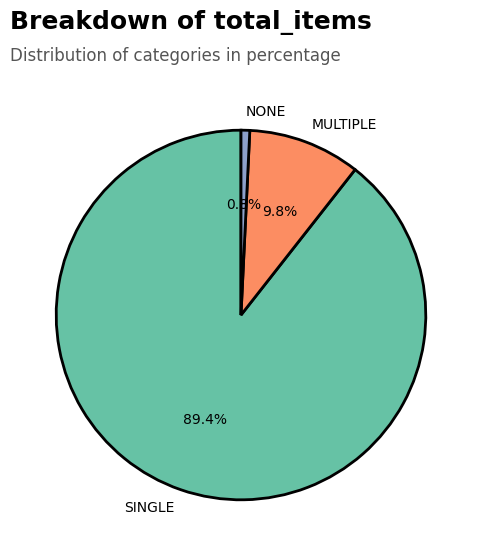

In [28]:
plt.figure(figsize=(6,6))
P.plot_pie('total_items',data)

- Approx 90% of observations have single total items

**total_order_value, total_freight, avg_price,avg_freight,total_paid_value**

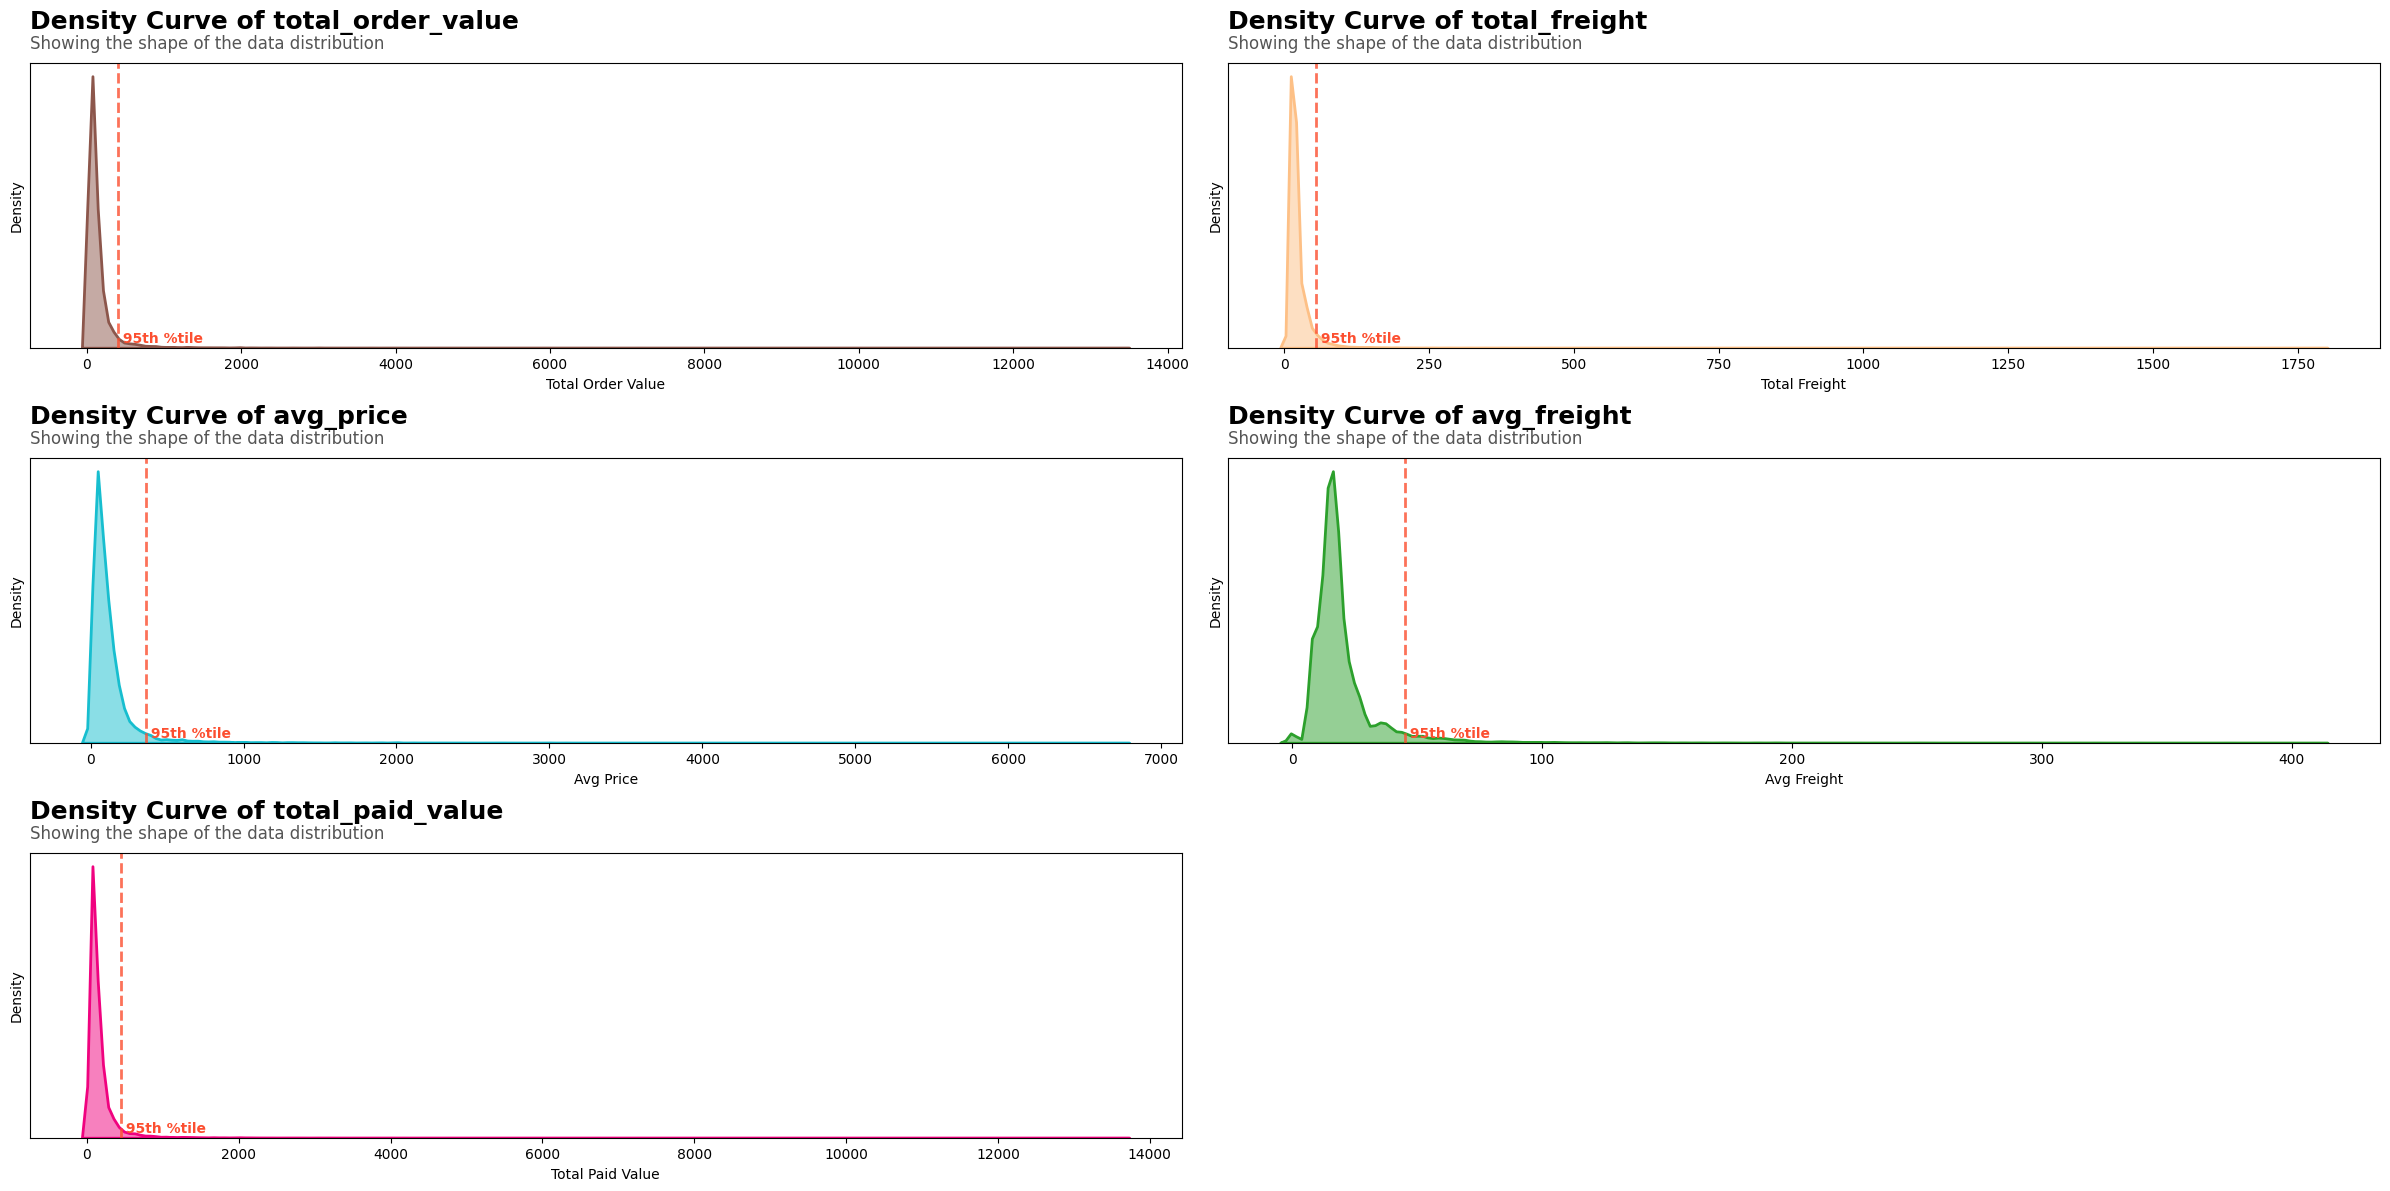

In [34]:
cols = ['total_order_value','total_freight','avg_price','avg_freight','total_paid_value']
plt.figure(figsize=(24,12))
limit = len(cols)
for i,col in enumerate(cols):
    if i>limit:
        break
    plt.subplot(3,2,i+1)
    P.plot_kde(col,data)
plt.tight_layout()
plt.show()